# Generating a set of locally efficient designs
This code is written in Julia, to run it, ensure that your kernel is a *Julia* kernel and *not* Python.

This notebook demonstrates how to generate a set of approximately *locally* pareto efficient robot designs using the code in the source directory. This aim is achieved by first solving an extreme linear scalarization problem (a single objective task), and then using a continuation procedure to systematically constrain the objective function values and generate further solutions.

# Linear scalarization problems
Consider a biobjective optimization problem, which we might write as $$ \min_{x \in \mathcal{X}} \{f_1(x),f_2(x)\}$$.

A linear scalarization problem converts this into a regular optimization problem by minimizing a convex combination of the objectives. Specifically, given some $\lambda \in (0,1)$, we solve $$\min_{x \in \mathcal{X}} \lambda f_1(x) + (1-\lambda) f_2(x)$$.

It is well known that all solutions to linear scalarization problems are pareto efficient. The converse is generally *not* true, due to the fact that the pareto front is usually not convex.

# Constraint methods
An alternative approach to scalarizing our problem is to constrain one of the objective values. For instance, given some $\epsilon \in \mathbb{R}$, we could try to solve $$\min_{x \in \mathcal{X}} f_1(x) \text{ s.t. } f_2(x) < \epsilon$$ 

It is not hard to show that all solutions to such constrained problems are pareto efficient, and the converse *is* true as well.

In [140]:
using LinearAlgebra
include("../HopperHandshake.jl") # reloading HopperHandshake.jl will trigger lots of recompilation

Main.Optimization

In [174]:
# going to get an initial guess first to solving a linear scalarization problem, using λ = .9
λ = .5
N = 20
x0 = Designs.random_sample(N^2)
cost = map(i->Optimization.cost(x0[:,i],λ),1:N^2)

# sort by cost
p = sortperm(cost)

# optimize a subset
cost = map(i->Optimization.lsp_optimize(x0[:,p[i]],λ;maxtime=10.)[1],1:N)

# select the best
x0 = x0[:,p[argmin(cost)]]

14-element Vector{Float64}:
  1.781182778546335
  1.3296151196937402
  2.6222772511344017
  1.9786929908793418
  0.9607418876844281
  0.5633305789166443
  3.430477834186595
 -2.1751565554901036
  1.5013574229227644
  0.3205528701145567
  2.563278944332155
  3.6495426510211684
  0.7529279005004175
  1.9942451907443346

In [175]:
# next we attempt to solve the scalarization problem
minf, minx, ret = Optimization.lsp_optimize(x0,λ;maxtime=30.,ftol_rel = 1e-16)
xstar = minx
error,weight = Optimization.stationarity_test(minx;tol=1e-9)
# run the stationarity test to check first-order efficiency conditions

(-1.7341547821717116e-8, 0.5000000103343464)

# A continuation approach to generating pareto efficient points
We can use our locally pareto $x^\star$ corresponding to $\lambda \approx 0.5$ to generate nearby solutions which represent a tradeoff between the objective functions. Initially we will trade off the objective values in a way that is like "decreasing" the value of $\lambda$. In otherwords, we will decrease $f_2(x)$ and the expense of increasing $f_1(x)$. In the following cell, we will decrease $f_1(x)$ at the expense of $f_2(x)$.

This will be accomplished in an iterative fashion. Let $x_0 = x^\star$ from the above linear scalarization problem, and let $\Delta > 0.$. We search for a new $x_k$ as follows, $$x_k = \argmin_{x \in \mathcal{X}} \{f_1(x)\} \text{ s.t. } f_2(x) < f_2(x_{k-1})-\Delta$$

To speed up this process, we will use the last solution $x_{k-1}$ as an initial guess for $x_k$ in our solver.

In [185]:
f1(x) = Hopper.cost(x)                  # the value of f1(x) will be the optimization objective
df1(x) = Hopper.cost_grad(x)
f2(x) = Handshake.cost(x)               # the value of f2(x) will be constrained
df2(x) = Handshake.cost_grad(x)

N = 30                                  # number of iterations we will attempt
Δ = 0.1                                 # step change in f2 value
x1 = zeros((length(minx),N))             
x1[:,1] = xstar                          

for i=2:N
    ϵ = f2(x1[:,i-1])-Δ
    minf,minx,ret = Optimization.constraint_optimize(
                        f1,
                        df1,
                        f2,
                        df2,
                        x1[:,i-1],
                        ϵ;
                        ftol_rel=1e-12,
                        maxtime=60.
                    )
    if norm(minx-x1[:,i-1]) < Δ^2
        x1 = x1[:,1:i-1]
        break
    end
    x1[:,i] = minx
end

In [186]:
# now switch hopper and handshake to trade off in the other direction
f1(x) = Handshake.cost(x)
df1(x) = Handshake.cost_grad(x)
f2(x) = Hopper.cost(x)
df2(x) = Hopper.cost_grad(x)

N = 30                                  # number of iterations we will attempt
Δ = 0.1                                 # step change in f2 value
x2 = zeros((length(minx),N))             
x2[:,1] = xstar                          

for i=2:N
    ϵ = f2(x2[:,i-1])-Δ
    minf,minx,ret = Optimization.constraint_optimize(
                        f1,
                        df1,
                        f2,
                        df2,
                        x2[:,i-1],
                        ϵ;
                        ftol_rel=1e-16,
                        maxtime=60.
                    )
    if norm(minx-x2[:,i-1]) < Δ^2
        x2 = x2[:,1:i-1]
        break
    end
    x2[:,i] = minx
end

In [187]:
x = hcat(x1,x2)

# now we can evaluate these solutions
stationarity = map(i->Optimization.stationarity_test(x[:,i];tol=1e-9),1:size(x,2))
error = map(i->stationarity[i][1],1:length(stationarity))
weight = map(i->stationarity[i][2],1:length(stationarity))

# evaluate costs
hopper = map(i->Hopper.cost(x[:,i]),1:size(x,2))
handshake = map(i->Handshake.cost(x[:,i]),1:size(x,2))

# sort by hopper
p = sortperm(hopper)
hopper[:] = hopper[p]
handshake[:] = handshake[p]
x[:,:] = x[:,p]


14×22 Matrix{Float64}:
  0.124656   0.138029   0.134105  …   2.0        2.0        2.0
  1.92608    1.99563    2.0           2.0        2.0        2.0
  2.49595    2.36622    2.4           0.925814   0.955382   0.967088
  1.5708     1.57081    1.9042        2.35619    2.35619    2.35619
  0.125543   0.441429   2.0           2.0        2.0        2.0
  1.97382    1.99979    1.48587   …   2.0        2.0        2.0
  2.43318    1.94089    2.68379       1.92963    1.89609    1.77701
 -1.5708    -1.57082   -1.5708       -2.35619   -2.35619   -2.35619
  0.987477   0.98934    0.966456      1.02106    2.0        2.0
  1.16116    1.16       1.15692       0.1        0.1        0.1
  1.19182    1.19314    1.19655   …   4.0        4.0        4.0
  2.92942    2.93601    2.87157       1.99447    2.28362    2.37188
  0.699967   0.699966   0.7           0.878213   0.964602   1.0
  1.99998    1.99998    2.0           1.82179    1.7354     1.7

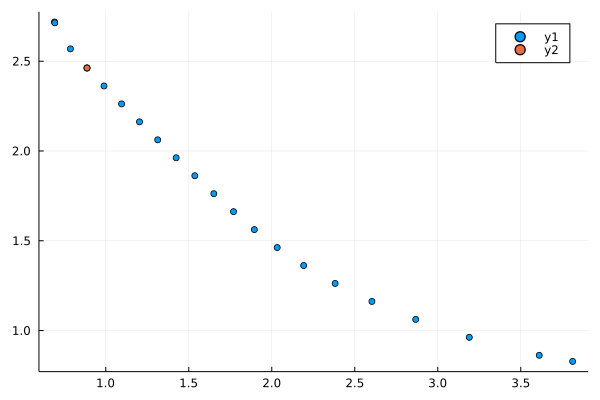

In [188]:
using Plots
plt = scatter(hopper,handshake)
scatter(plt, [Hopper.cost(xstar)], [Handshake.cost(xstar)])